In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import torch
import glob
from graph_functions import image_to_graph, unflatten, flatten
from utils import add_positional_encoding

import warnings
warnings.filterwarnings("ignore")

In [4]:
mask = np.isnan(xr.open_zarr('data/era5_hb_daily.zarr').siconc.isel(time=0)).values
# ds = xr.open_zarr('data/era5_hb_daily.zarr')
ds = xr.open_mfdataset(glob.glob('data/hb_era5_glorys_nc/hb_era5_glorys_*.nc'))

mask = np.isnan(ds.isel(time=0).siconc).values

# ds = ds[['siconc', 't2m']]

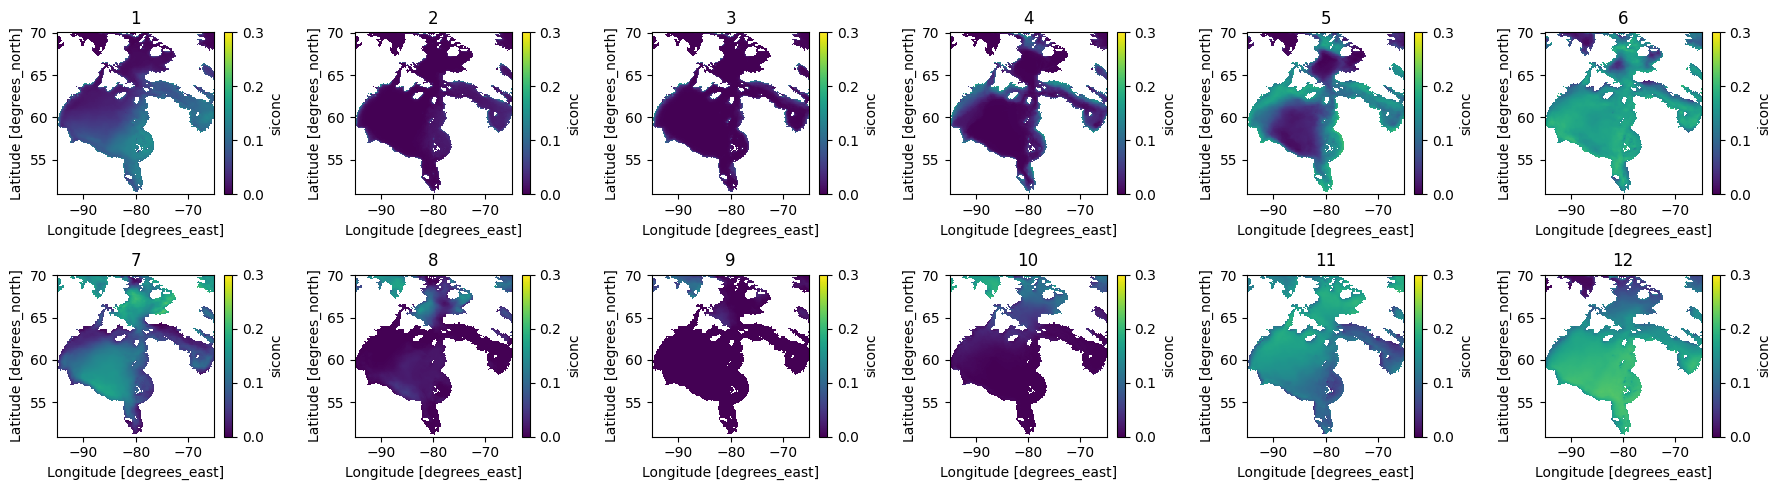

In [204]:
fig, axs = plt.subplots(2, 6, figsize=(18, 5))
for i, month in enumerate(range(1, 13)):
    months = ((month - 2) % 12 + 1, month, month % 12 + 1)
    ds.sel(time=ds.time.dt.month.isin(months)).siconc.fillna(0).var('time').where(~mask).plot(ax=axs.flatten()[i], vmin=0, vmax=0.3)
    axs.flatten()[i].set_title(month)

plt.tight_layout()
plt.show()

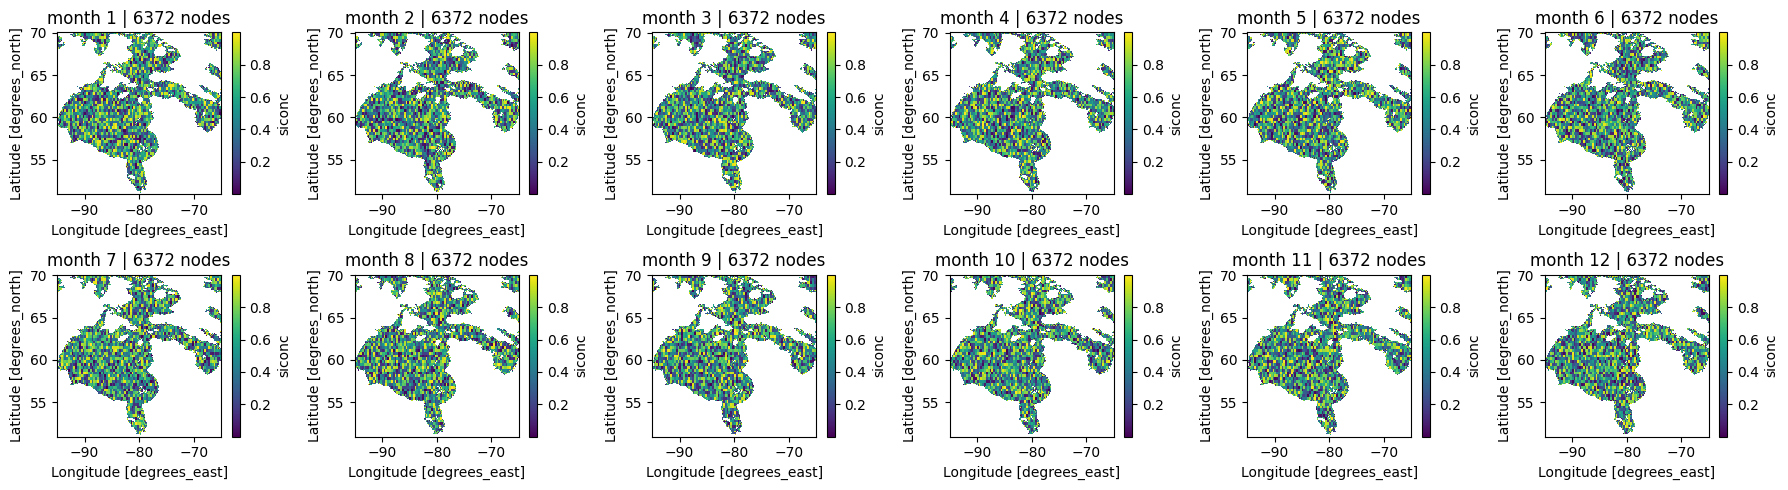

In [210]:
fig, axs = plt.subplots(2, 6, figsize=(18, 5))
for i, month in enumerate(range(1, 13)):
    months = ((month - 2) % 12 + 1, month, month % 12 + 1, month % 12 + 2)
    arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
    arr = arr_xr.values
    arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
    arr = add_positional_encoding(arr)

    image_shape = mask.shape#(77, 121)

    data = image_to_graph(arr, thresh=1, max_grid_size=4, mask=mask, use_edge_attrs=True, resolution=0.25)
    
    data['data'][0] = torch.Tensor(np.random.random(data['data'][0].shape))

    arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

    arr_xr.values = arr[0, :, :, 0]
    arr_xr.where(~mask).plot(ax=axs.flatten()[i])
    axs.flatten()[i].set_title(f'month {month} | {len(data["graph_nodes"])} nodes')

plt.tight_layout()
plt.show()

In [229]:
np.apply_along_axis

<function numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)>

In [232]:
np.unique(np.apply_along_axis(str, 1, np.array(data['edge_index'].T)), return_counts=True)

(array(['[ 0 54]', '[ 1 55]', '[ 13 101]', ..., '[998 997]', '[999 996]',
        '[999 997]'], dtype='<U11'),
 array([1, 4, 1, ..., 1, 1, 1]))

In [218]:

for l in data['edge_index'].T:
    for ll in data['edge_index'].T:
        

tensor([[6369, 6368],
        [6371, 6360],
        [6370, 6368],
        ...,
        [   1,   55],
        [   0,    1],
        [   0,   54]])

In [215]:
(data['edge_index'][0] == data['edge_index'][1]).sum()

tensor(28986)

Text(0.5, 1.0, 'month 6 | 1732 nodes')

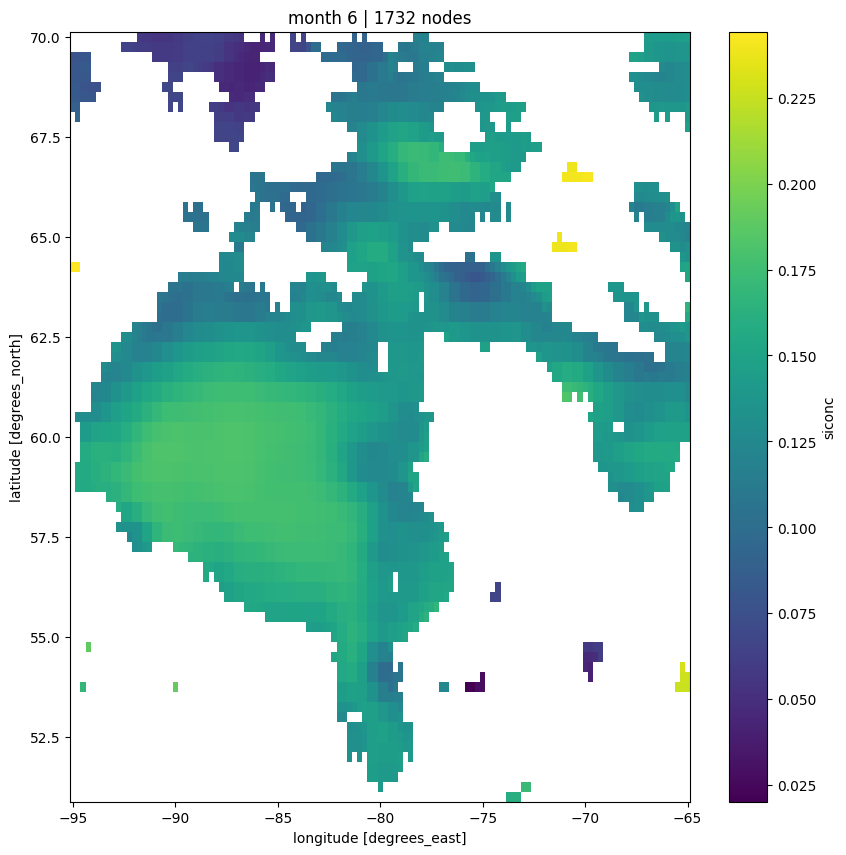

In [62]:
fig = plt.figure(figsize=(10, 10))
month = 6
months = ((month - 2) % 12 + 1, month, month % 12 + 1, month % 12 + 2)
arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
arr = arr_xr.values
arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
arr = add_positional_encoding(arr)

image_shape = mask.shape#(77, 121)

data = image_to_graph(arr, thresh=10, max_grid_size=2, mask=mask, use_edge_attrs=True, resolution=0.25)

# data['data'][0] = torch.Tensor(np.random.random(data['data'][0].shape))

arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

arr_xr.values = arr[0, :, :, 0]
arr_xr.where(~mask).plot()
plt.title(f'month {month} | {len(data["graph_nodes"])} nodes')

In [ ]:
fig = plt.figure(figsize=(10, 10))
month = 6
months = ((month - 2) % 12 + 1, month, month % 12 + 1, month % 12 + 2)
arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
arr = arr_xr.values
arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
arr = add_positional_encoding(arr)

image_shape = mask.shape#(77, 121)

data = image_to_graph(arr, thresh=10, max_grid_size=2, mask=mask, use_edge_attrs=True, resolution=0.25)

# data['data'][0] = torch.Tensor(np.random.random(data['data'][0].shape))

arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

arr_xr.values = arr[0, :, :, 0]
arr_xr.where(~mask).plot()
plt.title(f'month {month} | {len(data["graph_nodes"])} nodes')

In [265]:
years = range(2010, 2018)
for year in years:
    arr = ds.sel(time=ds.time.dt.year == year).to_array().values  # (n_samples, w, h, c)
    arr = np.nan_to_num(np.moveaxis(arr, 0, -1))
    arr = torch.Tensor(arr)
    arr = add_positional_encoding(arr)
    

    arr = flatten(arr, data['mapping'], data['n_pixels_per_node'], mask=~mask)
    
    with open(f'data/hb_era5_glorys_np/hb_era5_glorys_{year}.npy', 'wb') as f:
        np.save(f, arr)

Text(0.5, 1.0, '2017-06-19 | 1732 nodes')

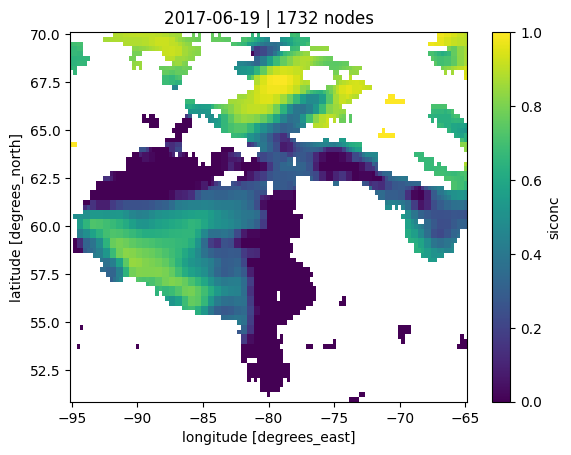

In [65]:
year = 2017
arr = ds.sel(time=ds.time.dt.year == year).to_array()  # (n_samples, w, h, c)
dt = arr.isel(time=169).time.values
arr = np.nan_to_num(np.moveaxis(arr.values, 0, -1))
arr = torch.Tensor(arr)
arr = add_positional_encoding(arr)


arr = flatten(arr, data['mapping'], data['n_pixels_per_node'], mask=~mask)

arr = unflatten(arr, data['mapping'], image_shape, mask=~mask)

arr_xr.values = arr[169, :, :, 0]
arr_xr.where(~mask).plot()
plt.title(f'{str(dt)[:10]} | {len(data["graph_nodes"])} nodes')

Text(0.5, 1.0, '2017-06-19 | Full res')

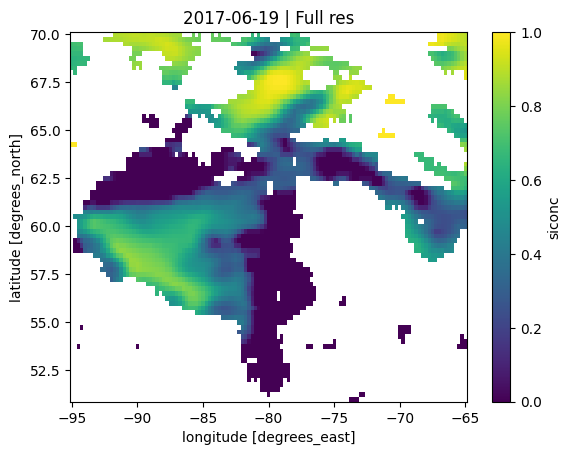

In [67]:
ds.sel(time=ds.time.dt.year == year).fillna(0).where(~mask).siconc.isel(time=169).plot()
plt.title(f'{str(dt)[:10]} | Full res')

Text(0.5, 1.0, 'month 6 | 1354 nodes')

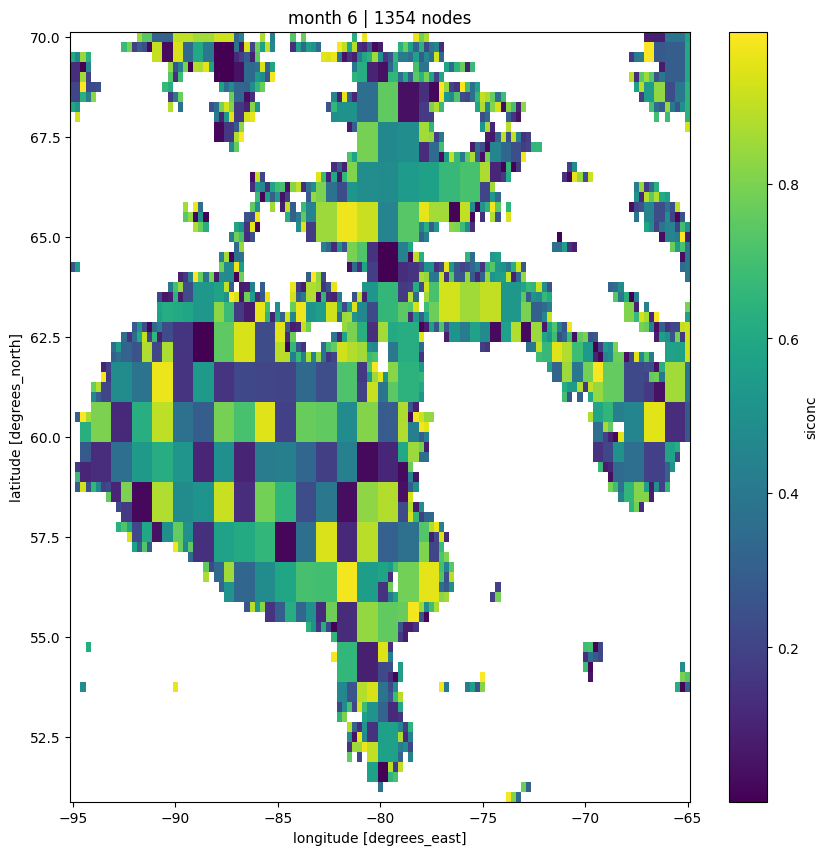

In [189]:
fig = plt.figure(figsize=(10, 10))
month = 6
months = ((month - 2) % 12 + 1, month, month % 12 + 1, month % 12 + 2)
arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
arr = arr_xr.values
arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
arr = add_positional_encoding(arr)

image_shape = mask.shape#(77, 121)

data = image_to_graph(arr, thresh=1, max_grid_size=4, mask=mask, use_edge_attrs=True, resolution=0.25)

data['data'][0] = torch.Tensor(np.random.random(data['data'][0].shape))

arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

arr_xr.values = arr[0, :, :, 0]
arr_xr.where(~mask).plot()
plt.title(f'month {month} | {len(data["graph_nodes"])} nodes')

In [129]:
fig, axs = plt.subplots(2, 6, figsize=(18, 5))
for i, month in enumerate(range(1, 13)):
    months = ((month - 2) % 12 + 1, month, month % 12 + 1)
    arr_xr = ds.sel(time=ds.time.dt.month.isin(months)).siconc.var('time')
    arr = arr_xr.values
    arr = torch.Tensor(np.expand_dims(np.nan_to_num(arr), (0, -1)))
    arr = add_positional_encoding(arr)

    image_shape = (77, 121)

    data = image_to_graph(arr, thresh=0.05, max_grid_size=64, mask=mask, use_edge_attrs=True, resolution=0.25)

    arr = unflatten(data['data'], data['mapping'], image_shape, mask=~mask)

    arr_xr.values = arr[0, :, :, 0]
    arr_xr.where(~mask).plot(ax=axs.flatten()[i])
    axs.flatten()[i].set_title(f'month | {len(data["graph_nodes"])} nodes')

plt.tight_layout()
plt.show()

<xarray.DataArray 'siconc' (latitude: 77, longitude: 121)>
dask.array<moment_agg-aggregate, shape=(77, 121), dtype=float32, chunksize=(39, 61), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 51.0 51.25 51.5 51.75 ... 69.5 69.75 70.0
  * longitude  (longitude) float32 -95.0 -94.75 -94.5 ... -65.5 -65.25 -65.0

In [86]:
def create_static_heterogeneous_graph(image_shape, max_grid_size, mask, use_edge_attrs=True, resolution=0.25, device=None):
    arr = torch.zeros(size=(1, *image_shape, 1)).to(device)
    arr = add_positional_encoding(arr)
    graph_structure = image_to_graph(arr, thresh=np.inf, max_grid_size=max_grid_size, mask=mask, use_edge_attrs=use_edge_attrs, resolution=resolution)
    del graph_structure['data']
    return graph_structure

def get_nan_nodes(mask, graph_structure):
    return np.where(~mask.flatten() @ graph_structure['mapping'].to_dense().numpy().T == 0)[0]

def replace_with_map(arr, map_):
    return np.vectorize(map_.get)(arr)

def create_static_homogeneous_graph(image_shape, max_grid_size, mask, use_edge_attrs=True, resolution=0.25, device=None):
    
    # First create a heterogeneous graph without a mask (homogeneous other than at the borders)
    graph_structure = create_static_heterogeneous_graph(image_shape, max_grid_size, None, use_edge_attrs, resolution, device)
    
    # Remove any nodes which entirely overlap the mask
    nodes_to_delete = get_nan_nodes(mask, graph_structure)

    edge_mask = [not (node.item() in nodes_to_delete or neighbor.item() in nodes_to_delete) for node, neighbor in graph_structure['edge_index'].T]
    graph_structure['edge_index'] = graph_structure['edge_index'][:, edge_mask]
    graph_structure['edge_attrs'] = graph_structure['edge_attrs'][edge_mask]

    node_mask = np.array(list(set(graph_structure['graph_nodes']) - set(nodes_to_delete)))
    graph_structure['graph_nodes'] = graph_structure['graph_nodes'][node_mask]
    graph_structure['mapping'] = graph_structure['mapping'][node_mask]
    graph_structure['n_pixels_per_node'] = graph_structure['n_pixels_per_node'][node_mask]
    
    # Since we removed nodes, "rename" them so they are from (0, n) for n nodes
    node_mapping = {old_node: new_node for new_node, old_node in enumerate(graph_structure['graph_nodes'])}

    graph_structure['graph_nodes'] = replace_with_map(graph_structure['graph_nodes'], node_mapping)
    graph_structure['edge_index'] = replace_with_map(graph_structure['edge_index'], node_mapping)
    
    return graph_structure


graph_structure = create_static_heterogeneous_graph(mask.shape, 4, mask)
# graph_structure = create_static_homogeneous_graph(mask.shape, 4, mask)

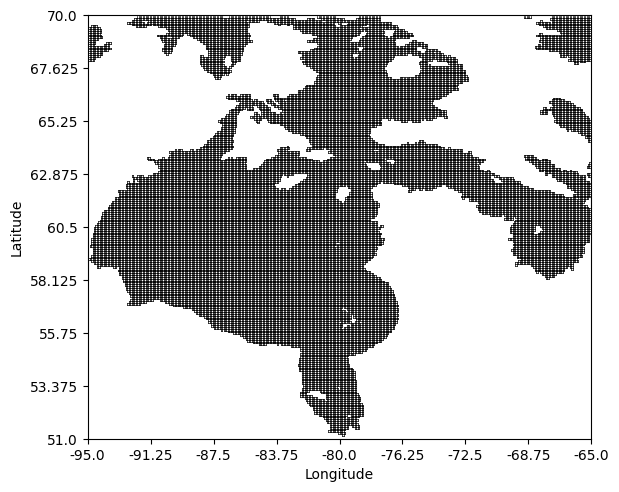

In [82]:
from graph_functions import plot_contours
import matplotlib.ticker as ticker

labels = torch.einsum('i,ijk->ijk',
                      torch.Tensor(graph_structure['graph_nodes']),
                      torch.Tensor(graph_structure['mapping'].reshape(-1, *mask.shape))
                     ).sum(0)

labels = labels.numpy().astype(int)

fig, ax = plt.subplots(figsize=(6.5, 5.5))
ax.set_xlim(0, mask.shape[1])
ax.set_ylim(0, mask.shape[0])
ax.xaxis.set_major_locator(ticker.LinearLocator(9))
ax.yaxis.set_major_locator(ticker.LinearLocator(9))
ax.set_yticklabels(np.linspace(ds.latitude.values.min(), ds.latitude.values.max(), 9))
ax.set_xticklabels(np.linspace(ds.longitude.values.min(), ds.longitude.values.max(), 9))
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plot_contours(ax, labels)

In [87]:
len(graph_structure['graph_nodes'])

6372

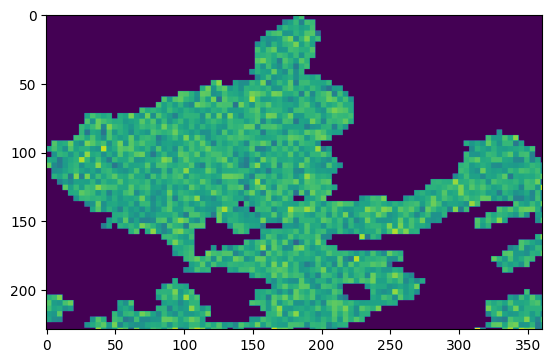

In [133]:
arr = np.random.random(size=ds.isel(time=150).siconc.values.shape)
arr = np.nan_to_num(arr)
arr = torch.Tensor(np.expand_dims(arr, (0, -1)))
arr = flatten(arr, graph_structure['mapping'], graph_structure['n_pixels_per_node'])
arr = unflatten(arr, graph_structure['mapping'], mask.shape) 
# arr = np.where(~mask, arr[0, ..., 0], np.nan)
arr = np.where(~mask, arr[0, ..., 0], arr[0, ..., 0])

plt.imshow(arr)

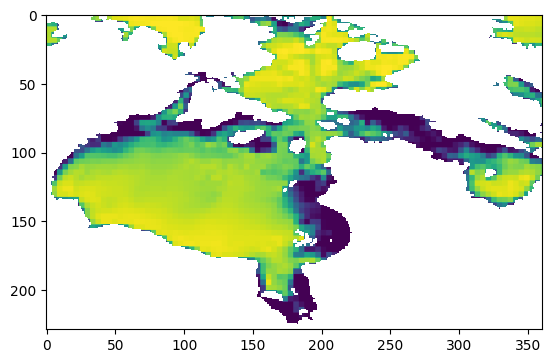

In [65]:
arr = ds.isel(time=150).siconc.values
arr = np.nan_to_num(arr)
arr = torch.Tensor(np.expand_dims(arr, (0, -1)))
arr = flatten(arr, graph_structure['mapping'], graph_structure['n_pixels_per_node'])
arr = unflatten(arr, graph_structure['mapping'], mask.shape) 
arr = np.where(~mask, arr[0, ..., 0], np.nan)

plt.imshow(arr[::-1])

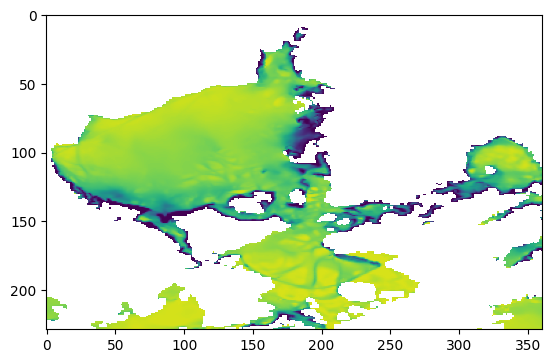

In [95]:
plt.imshow(ds.isel(time=150).siconc.values)